In [1]:
#  displays plots directly in this notebook as images
%matplotlib inline
import numpy as np       # the NumPy library for fast matrix and vector data types and math operations
import matplotlib.pyplot as plt   # functions for plotting, loaded under a convenient name alias 'plt'
import xarray as xr      # matrix and vector containers with labeled axes, used for signals
import holoviews as hv   # a different plotting web-based library mainly for interactive display
import hvplot.xarray     # xaray wrappers for holoviews
import xrscipy           # additional SciPy xarray-compatible wrappers
import xrscipy.signal as dsp    # subpackage convenience: functions for digital signal processing of signals
import xrrandom          # for random sammpling parametrized by xarray objects
import cdb_extras.xarray_support as cdbxr  # a convenient Python library for accessing the COMPASS databaseb

In [2]:
shot = cdbxr.Shot(18447)

In [3]:
def plot_signals(n_shot, start=0, end=2000):

    shot = cdbxr.Shot(n_shot)
    
    signal_APD = shot['APD.light_profile'].sel(time=slice(start, end)).data[:,14]
    time_APD = shot['APD.light_profile'].sel(time=slice(start, end)).time

    signal_Mirnov = shot.Mirnov_A_rad_02_RAW.sel(time=slice(start, end)).data
    time_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(start, end)).time
    
    
    plt.plot(time_Mirnov, signal_Mirnov, c='b', label='Mirnov')
    plt.plot(time_APD, signal_APD, c='g', label='APD')
    
    plt.legend()

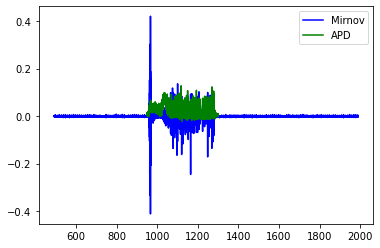

In [4]:
# plot to show entire signals
plot_signals(18447)

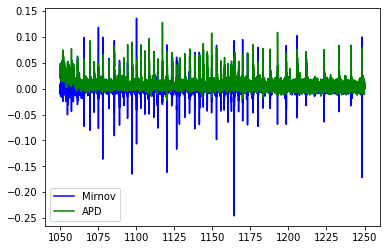

In [5]:
# plot to show the signals during H-mode (timing taken from logbook)
plot_signals(18447, 1050, 1250)

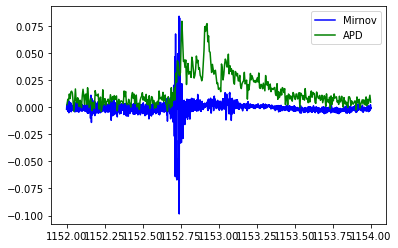

In [6]:
# plot to show the signals during a single ELM
plot_signals(18447, 1152, 1154)

In [8]:
# these two time series are not defined on the same time points. We obtain this by averaging!
def time_series_average(time_arr, signal_arr, time_step, start, end):

    assert len(time_arr) == len(signal_arr)
    assert len(time_arr) > (end - start) / time_step, 'too short time_step!'
    
    time = np.arange(start, end-time_step, time_step)
    
    # optimize this?
    signal_ave = np.array([signal_arr[(t<=time_arr)&(time_arr<t+time_step)].mean() for t in time])
    time += time_step / 2
    
    return time, signal_ave

In [14]:
def plot_signals_averaged(n_shot, start=0, end=2000, dt=None):

    shot = cdbxr.Shot(n_shot)
    
    signal_APD = shot['APD.light_profile'].sel(time=slice(start, end)).data[:,14]
    time_APD = shot['APD.light_profile'].sel(time=slice(start, end)).time
    
    signal_Mirnov = shot.Mirnov_A_rad_02_RAW.sel(time=slice(start, end)).data
    time_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(start, end)).time

    dt_min = max(np.diff(time_APD).max(), np.diff(time_Mirnov).max())
    if dt is None:
        dt = dt_min
    elif dt < dt_min:
        dt = dt_min
        import warnings
        warnings.warn('time step too small, set to minimum value')
        

    t_APD, s_APD = time_series_average(time_APD, signal_APD, dt, start, end)
    t_Mirnov, s_Mirnov = time_series_average(time_Mirnov, signal_Mirnov, dt, start, end)
    
    plt.plot(t_Mirnov, s_Mirnov, c='b', label='Mirnov')
    plt.plot(t_APD, s_APD, c='g', label='APD')
    
    plt.legend()

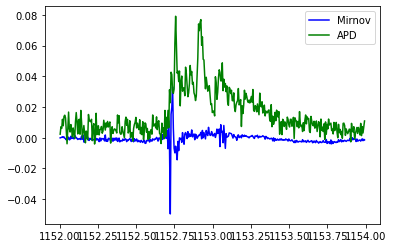

In [15]:
# plot to show the similar timing averaged signals during a single ELM
plot_signals_averaged(18447, 1152, 1154)

In [16]:
# Code from previous year, sent to us by Miklós

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AR
from scipy.stats import f


import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

def get_gcc(x, y, d=2):
    """Computes F value wether y Granger causes x

    :param numpy.ndarray x: target array shape (1D)
    :param numpy.ndarray y: source array (1D)
    :param int d: maxlag of autoregression
    :return: log(F) value for y -> x
    :rtype: float

    """
    # for definition of AR => (https://en.wikipedia.org/wiki/Autoregressive_model#Definition)
    ar = AR(x)
    ar_fit = ar.fit(maxlag=d)
    var = VAR(np.array([x, y]).T)
    var_fit = var.fit(maxlags=d)
   
  
    return np.log(ar_fit.resid.var() / var_fit.resid.var(axis=0)[0])



In [17]:
from scipy.signal import savgol_filter

def plot_gcc(n_shot, start=0, end=2000, dt=None, r_apd=14, window=3):
    assert window % 2 == 1, 'window must be odd!'
    assert isinstance(window, int)
    
    shot = cdbxr.Shot(n_shot)
    
    signal_APD = shot['APD.light_profile'].sel(time=slice(start, end)).data[:,r_apd]
    time_APD = shot['APD.light_profile'].sel(time=slice(start, end)).time
    
    signal_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(start, end)).data
    time_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(start, end)).time

    dt_min = max(np.diff(time_APD).max(), np.diff(time_Mirnov).max())
    if dt is None:
        dt = dt_min
        print(dt)
    elif dt < dt_min:
        dt = dt_min
        print(f'time step too small, set to minimum value dt={dt_min}')

    t_APD, s_APD = time_series_average(time_APD, signal_APD, dt, start, end)
    t_Mirnov, s_Mirnov = time_series_average(time_Mirnov, signal_Mirnov, dt, start, end)
    
    assert np.array_equal(t_APD, t_Mirnov)
    
    
    t_gcc = np.zeros(t_APD.size - window + 1)
    sxy_gcc = np.zeros(t_gcc.shape)
    syx_gcc = np.zeros(t_gcc.shape)
    
    for i, _ in enumerate(t_gcc):
        t_gcc[i] = t_APD[i+int((window-1)/2)]
        
        x = s_APD[i:i+window]
        y = s_Mirnov[i:i+window]
        sxy_gcc[i] = get_gcc(x, y)
        syx_gcc[i] = get_gcc(y, x)
    
    plt.figure(figsize=(20, 10))
    plt.plot(t_gcc, sxy_gcc, c='k', label='GCC Mirnov->APD')
    plt.plot(t_gcc, syx_gcc, 'k--', label='GCC APD->Mirnov')
    plt.plot(t_APD, s_APD/s_APD.max(), c='r', alpha=.6, label='APD')
    plt.plot(t_Mirnov, s_Mirnov/s_Mirnov.max(), c='b', alpha=.6, label='Mirnov')
    plt.legend()

0.010000000474974513


/sw/python/3.8-anaconda-2020.07/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, F

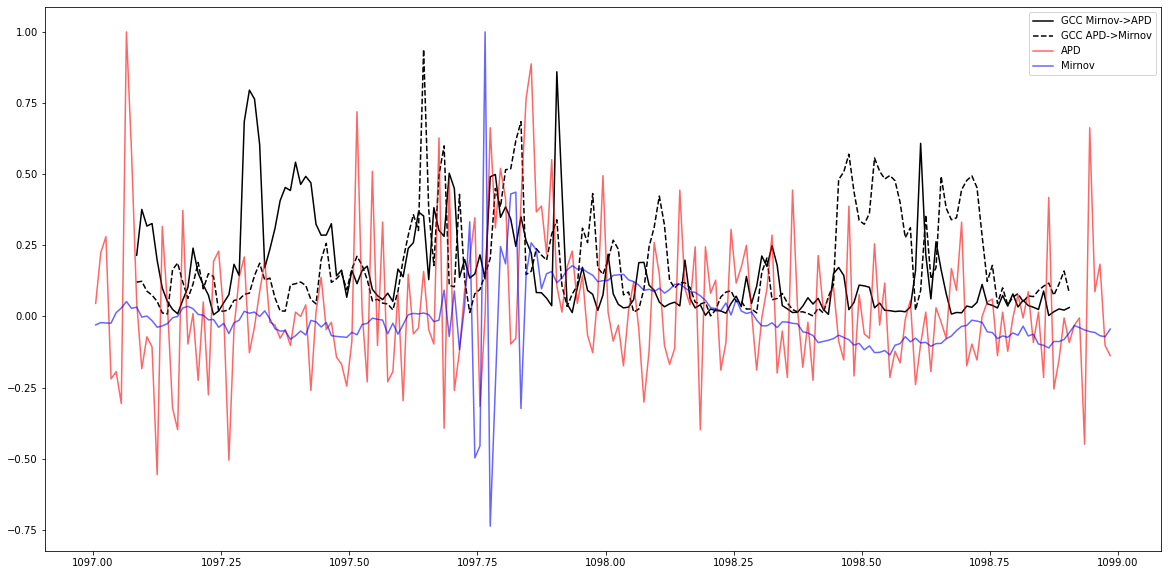

In [18]:
plot_gcc(17229, start=1097, end=1099, window=17)

0.0050000002374872565


/sw/python/3.8-anaconda-2020.07/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, F

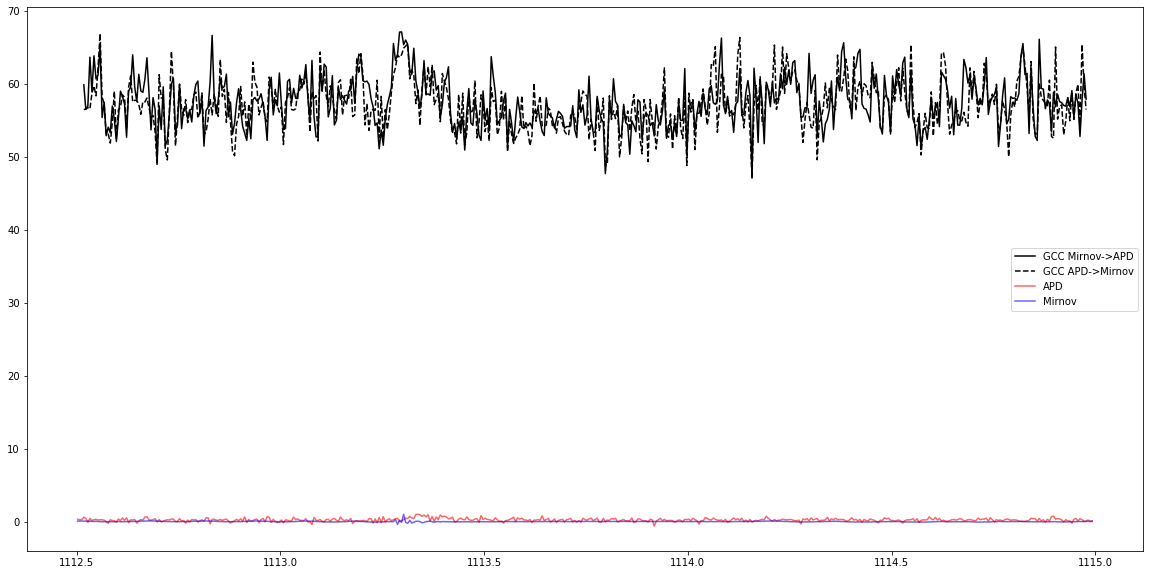

In [19]:
plot_gcc(17269, start=1112.5, end=1115, window=7)